<a href="https://colab.research.google.com/github/irakozej/Garbage_classifier-model/blob/main/Garbage_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PHASE 1: Dataset & Folder Setup

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os


## Image Preprocessing

In [3]:
# Install Kaggle CLI if not installed
!pip install -q kaggle

# Upload kaggle.json (API Key)
from google.colab import files
files.upload()  # Upload your kaggle.json here

# Move the kaggle.json to the right location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d mostafaabla/garbage-classification

# Unzip the dataset
!unzip -q garbage-classification.zip -d data/


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/mostafaabla/garbage-classification
License(s): ODbL-1.0
 85% 202M/239M [00:00<00:00, 715MB/s] 
100% 239M/239M [00:00<00:00, 624MB/s]


In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Rename folder
if not os.path.exists("data/train"):
    os.rename("data/Garbage classification", "data/train")

# Create test folder
os.makedirs("data/test", exist_ok=True)

# Move 20% of each class to test/
for class_name in os.listdir("data/train"):
    class_path = os.path.join("data/train", class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)
        os.makedirs(f"data/test/{class_name}", exist_ok=True)
        for img in test_imgs:
            shutil.move(os.path.join(class_path, img), f"data/test/{class_name}/{img}")


# PHASE 2: Building the Notebook and Model

## Step 1: Import Required Libraries

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix


## Step 2: Define Image Parameters

In [6]:
# Basic setup
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
DATA_DIR = "data"


##  Step 3: Create Data Generators

In [7]:
# Data Preprocessing
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20,
                                   width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "test"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

NUM_CLASSES = train_generator.num_classes


Found 12409 images belonging to 12 classes.
Found 3106 images belonging to 12 classes.


## Step 4: Build Transfer Learning Model (MobileNetV2)

In [8]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Step 5: Train the Model

In [9]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS,
    callbacks=[early_stop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 871s 2s/step - accuracy: 0.7053 - loss: 0.9813 - val_accuracy: 0.9111 - val_loss: 0.2843
Epoch 2/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 840s 2s/step - accuracy: 0.8712 - loss: 0.4189 - val_accuracy: 0.9208 - val_loss: 0.2376
Epoch 3/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 855s 2s/step - accuracy: 0.8859 - loss: 0.3563 - val_accuracy: 0.9285 - val_loss: 0.2186
Epoch 4/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 864s 2s/step - accuracy: 0.8915 - loss: 0.3337 - val_accuracy: 0.9298 - val_loss: 0.2086
Epoch 5/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 834s 2s/step - accuracy: 0.9086 - loss: 0.2844 - val_accuracy: 0.9301 - val_loss: 0.1971
Epoch 6/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 853s 2s/step - accuracy: 0.9096 - loss: 0.2736 - val_accuracy: 0.9324 - val_loss: 0.1989
Epoch 7/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 858s 2s/step - accuracy: 0.9105 - loss: 0.2749 - val_accuracy: 0.9324 - val_loss: 0.1929
Epoch 8/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 928s 2s/step - accuracy: 0.9124 - loss: 0.2650 - val_accu

## Step 6: Save Model

In [10]:
model.save("models/garbage_model.h5")


## Evaluate with Full Metrics

98/98 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step
              precision    recall  f1-score   support

     battery       0.97      0.95      0.96       189
  biological       0.98      0.96      0.97       197
 brown-glass       0.91      0.87      0.89       122
   cardboard       0.93      0.91      0.92       179
     clothes       0.99      0.99      0.99      1065
 green-glass       0.95      0.88      0.91       126
       metal       0.85      0.88      0.87       154
       paper       0.92      0.91      0.92       210
     plastic       0.84      0.84      0.84       173
       shoes       0.95      0.99      0.97       396
       trash       0.92      0.94      0.93       140
 white-glass       0.81      0.81      0.81       155

    accuracy                           0.94      3106
   macro avg       0.92      0.91      0.91      3106
weighted avg       0.94      0.94      0.94      3106



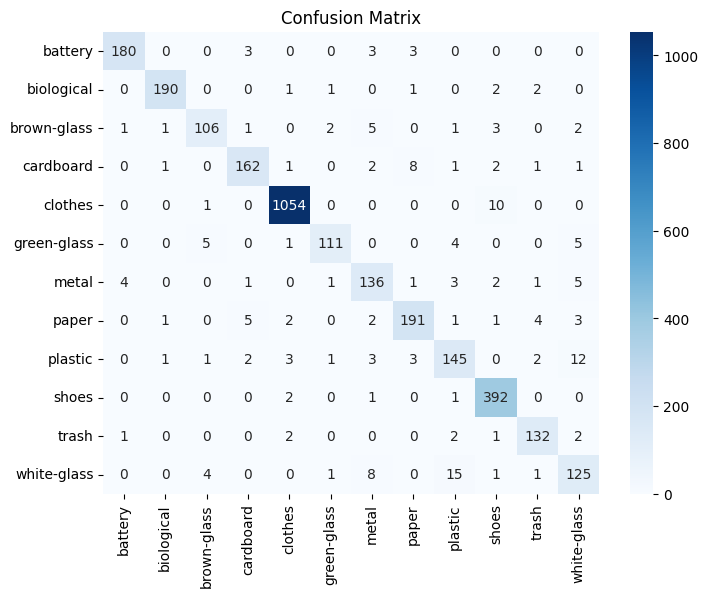

In [11]:
# Predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, xticklabels=class_labels, yticklabels=class_labels, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


### exposing FastAPI app to the public internet using ngrok

####  Install and set up pyngrok

In [33]:
!pip install pyngrok

In [34]:
from pyngrok import ngrok
ngrok.set_auth_token("2uXRP1lrXCRc7FANfSUSyxtsX28_6WmobP5GzBqvYya7sceqb")

In [68]:
# Run Uvicorn in background
import threading
import uvicorn

def run_app():
    uvicorn.run("app.main:app", host="0.0.0.0", port=8000)

threading.Thread(target=run_app).start()


In [67]:
from pyngrok import ngrok

# Kill all active tunnels
ngrok.kill()


In [69]:
# Reconnect and print new public URL
public_url = ngrok.connect(8000)
print("New Public FastAPI URL:", public_url)


New Public FastAPI URL: NgrokTunnel: "https://50b50e3e272a.ngrok-free.app" -> "http://localhost:8000"
